In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from skmultiflow.trees.hoeffding_tree import HoeffdingTree
from sklearn.tree import DecisionTreeClassifier
from MPD3 import MPD3
from tunning_parameter import Tunning

In [2]:
def get_data_batches(d):
	n_r , n_c = d.shape
	X_data = data.iloc[:,:n_c-1]
	y_data = data.iloc[:,n_c-1]
	n =int(n_r/30)
	b_X = [np.array(X_data[i:i+n]) for i in range(0,X_data.shape[0],n)]
	b_y = [np.array(y_data[i:i+n]) for i in range(0,y_data.shape[0],n)]
	return b_X,b_y

In [3]:
#pd.read_csv("test_data/"+ data_name)
data = pd.read_csv("data/streaming data/real-world/elec.csv") 
ensemble_clf = DecisionTreeClassifier()
base_clf = HoeffdingTree()
bootstrap_count = 100 #sys.argv[2]
X_batches , y_batches = get_data_batches(data)

In [4]:
p = Tunning(X_batches[0],y_batches[0])
quantile_percent,MPD_threshold = p.parameter_q_and_t()

In [8]:
print(quantile_percent,MPD_threshold )

1.0 0.6


In [6]:
MPD3_detector = MPD3(bootstrap_count,quantile_percent,MPD_threshold)

In [23]:
Train_X = X_batches[0]
Train_y = y_batches[0].flatten()
base_clf = base_clf.fit(Train_X,Train_y)
ensemble = MPD3_detector.ensemble_bootstrap(Train_X,Train_y)

batch_accuracy = []
result = []
for i in range(len(X_batches)-1):
    index = i+1
    y_pred = base_clf.predict(X_batches[index])
    batch_accuracy.append(accuracy_score(y_batches[index],y_pred))
    mpd_value = MPD3_detector.MPD_score(X_batches[index],ensemble)    
    
    if MPD3_detector.drift_check(mpd_value): 
        result.append("drift")                #drift
        #retrain the model
        Train_X = X_batches[index]
        Train_y = y_batches[index].flatten()
        base_clf = base_clf.partial_fit(Train_X,Train_y)
        ensemble = MPD3_detector.ensemble_bootstrap(Train_X,Train_y)
    else:
        result.append("No drift")            #no drift

In [15]:
Train_X = X_batches[0]
Train_y = y_batches[0].flatten()
base_clf = base_clf.fit(Train_X,Train_y)

batch_accuracy_no_update = []
for i in range(len(X_batches)-1):
    index = i+1
    y_pred = base_clf.predict(X_batches[index])
    batch_accuracy_no_update.append(accuracy_score(y_batches[index],y_pred))

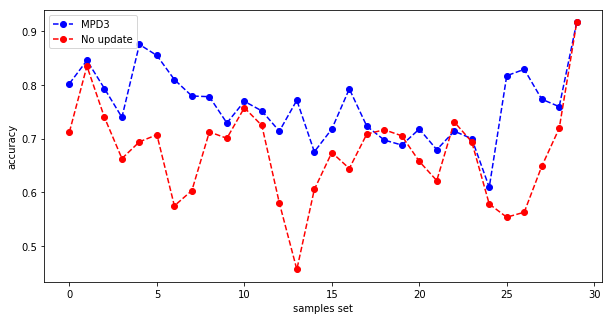

In [21]:
plt.xlabel("samples set")
plt.ylabel("accuracy")
lw = 2

plt.plot(batch_accuracy, linestyle='--', marker='o', color='b',label="MPD3")
plt.plot(batch_accuracy_no_update, linestyle='--', marker='o', color='r',label="No update")


plt.rcParams["figure.figsize"]=10,5
plt.legend(loc="best")
plt.show()

In [22]:
print("Mean of the accuracy of the data batches with drift detection     :"+str(np.mean(batch_accuracy)))
print("Mean of the accuracy of the data batches with no drift detection  :"+str(np.mean(batch_accuracy_no_update)))

Mean of the accuracy of the data batches with drift detection     :0.7608866813833702
Mean of the accuracy of the data batches with no drift detection  :0.6733149374540103
